#### Importing required packages and data

In [67]:
#Importing required packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False

In [3]:
# Reading in the data for daily price predictions
path = '.\data\gld_price_data.csv'
df = pd.read_csv(path)

#### Transformations - getting data in required format

In [7]:

# Changing date format into pandas datetime
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
# Checking date range of the data! We have data from 2008 - 2018
print("Data range of data")
print("Date from : ", min(df['Date']))
print("Date to : ", max(df['Date']))

Data range of data
Date from :  2008-01-02 00:00:00
Date to :  2018-05-16 00:00:00


In [11]:
# We have missing data for weekends and national holidays! We do not need to fill missing values as we are not looking for day trades. We will predict weekly
missing_date_list =  pd.date_range(start = '2008-01-02', end = '2018-05-16').difference(df['Date'])
missing_date_list

DatetimeIndex(['2008-01-05', '2008-01-06', '2008-01-12', '2008-01-13',
               '2008-01-19', '2008-01-20', '2008-01-21', '2008-01-26',
               '2008-01-27', '2008-02-02',
               ...
               '2018-04-27', '2018-04-28', '2018-04-29', '2018-05-04',
               '2018-05-05', '2018-05-06', '2018-05-11', '2018-05-12',
               '2018-05-13', '2018-05-15'],
              dtype='datetime64[ns]', length=1498, freq=None)

#### Plotting daily data

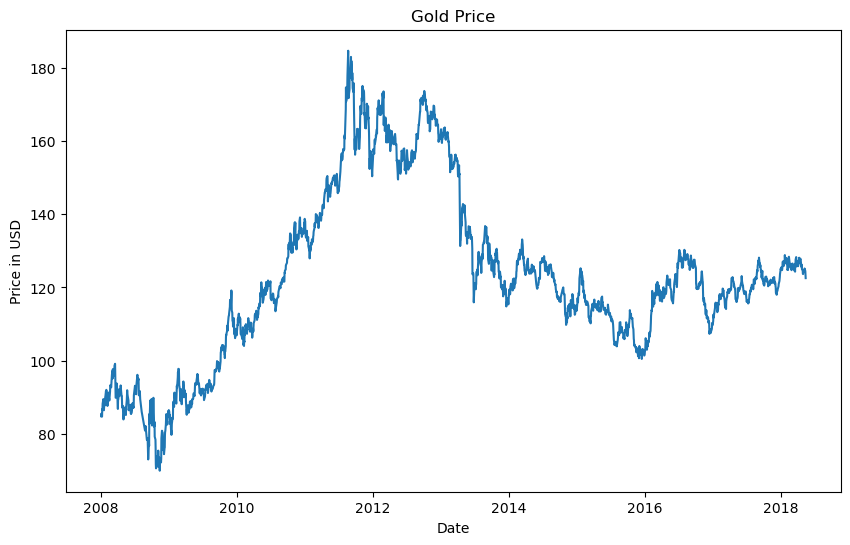

In [12]:
plt.figure(figsize=(10,6))
plt.title("Gold Price")
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.plot(df['Date'], df['GLD'])
plt.show()

In [15]:
# Daily data preview
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692
1,2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491
2,2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492
3,2008-01-07,1416.180054,84.769997,75.500000,15.053,1.468299
4,2008-01-08,1390.189941,86.779999,76.059998,15.590,1.557099


#### Getting weekly data by week start

In [18]:
# Creating week start column and summarizing (mean) based on the data
df['week_start'] = df['Date'] - df['Date'].dt.weekday.astype('timedelta64[D]')
weekly_data = df.groupby(['week_start']).mean().reset_index()

In [35]:
weekly_data.tail(10)

,week_start,SPX,GLD,USO,SLV,EUR/USD
530,2018-03-12,2759.430029,125.303999,12.3560,15.5340,1.234510
531,2018-03-19,2674.747949,125.850002,12.9540,15.4680,1.230844
532,2018-03-26,2629.260071,126.822500,13.1050,15.5150,1.236962
533,2018-04-02,2625.964966,126.452501,12.8000,15.4850,1.227742
534,2018-04-09,2644.052490,127.167502,13.2475,15.5975,1.234671
535,2018-04-16,2696.499939,127.707498,13.6100,15.9900,1.237075
536,2018-04-23,2652.797485,125.557503,13.7725,15.6550,1.218292
537,2018-04-30,2642.062500,124.057499,13.7250,15.3750,1.200326
538,2018-05-07,2691.352478,124.667499,14.2350,15.5750,1.189160
539,2018-05-14,2727.954956,123.516899,14.3929,15.5071,1.187575


In [94]:
# setting date as index for plotting
weekly_data_idx = weekly_data.set_index(['week_start'])

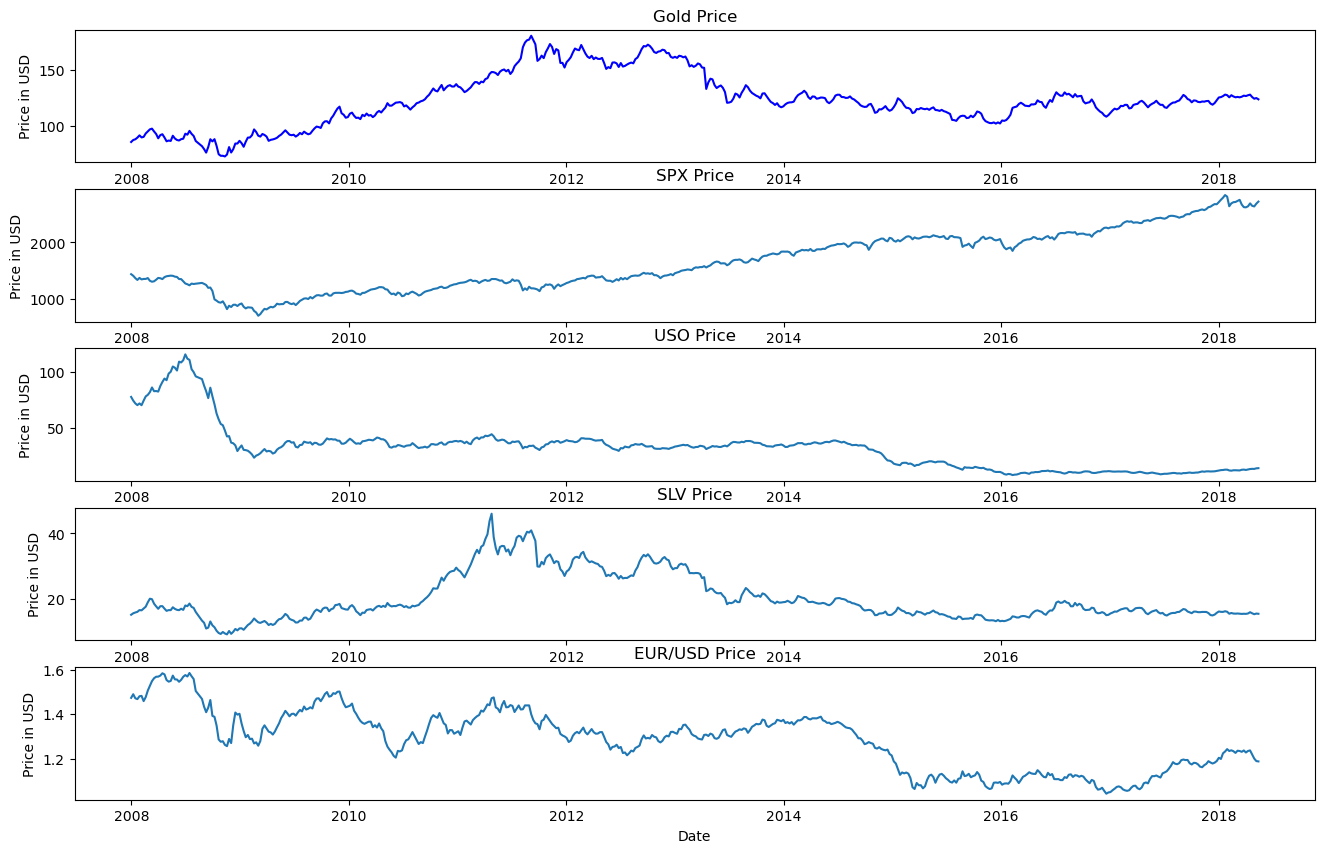

In [95]:
# figure size
plt.figure(figsize=(16,10))
#first figure
plt.figure(1)

#first subplot
plt.subplot(511)  
plt.title("Gold Price")
#plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.plot(weekly_data_idx['GLD'], 'b-')

#second subplot
plt.subplot(512)
plt.title("SPX Price")
#plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.plot(weekly_data_idx['SPX'])

#third subplot
plt.subplot(513)
plt.title("USO Price")
#plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.plot(weekly_data_idx['USO'])

#fourth subplot
plt.subplot(514)
plt.title("SLV Price")
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.plot(weekly_data_idx['SLV'])

#fourth subplot
plt.subplot(515)
plt.title("EUR/USD Price")
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.plot(weekly_data_idx['EUR/USD'])
plt.show()

#### Splitting test and train data for validating the model

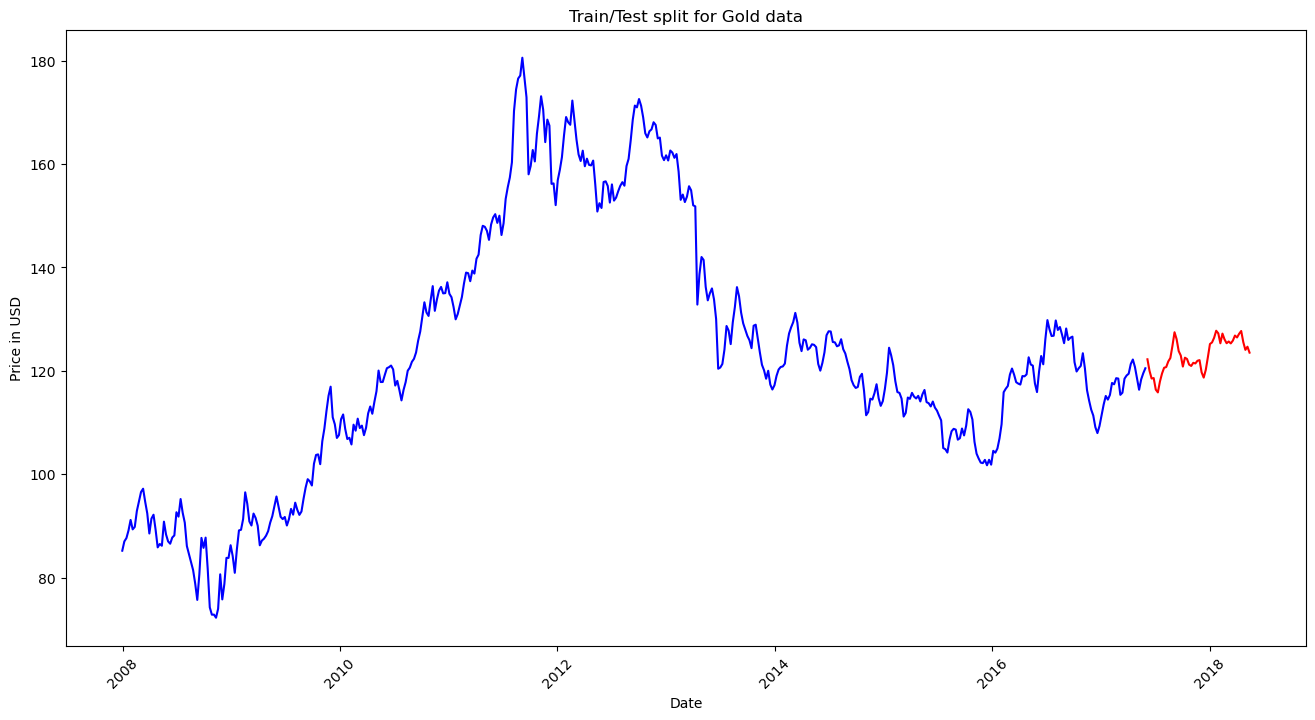

In [96]:
train = weekly_data_idx[weekly_data_idx.index < pd.to_datetime("2017-06-01", format='%Y-%m-%d')]
test =  weekly_data_idx[weekly_data_idx.index >= pd.to_datetime("2017-06-01", format='%Y-%m-%d')]

plt.plot(train['GLD'], color = "blue")
plt.plot(test['GLD'], color = "red")
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.xticks(rotation=45)
plt.title("Train/Test split for Gold data")
plt.show()

#### Checking stationarity

In [97]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations','Critical Value']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(train['GLD'])

ADF Test Statistic : -1.809272406738613
p-value : 0.37586801534216024
#Lags Used : 1
Number of Observations : 488
Critical Value : {'1%': -3.4438213751870337, '5%': -2.867480869596464, '10%': -2.5699342544006987}
weak evidence against null hypothesis,indicating it is non-stationary 


In [98]:
train['GLD-Diff1'] = train['GLD'] - train['GLD'].shift(1)

C:\Users\tyagi\AppData\Local\Temp\ipykernel_1472\2657538857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GLD-Diff1'] = train['GLD'] - train['GLD'].shift(1)


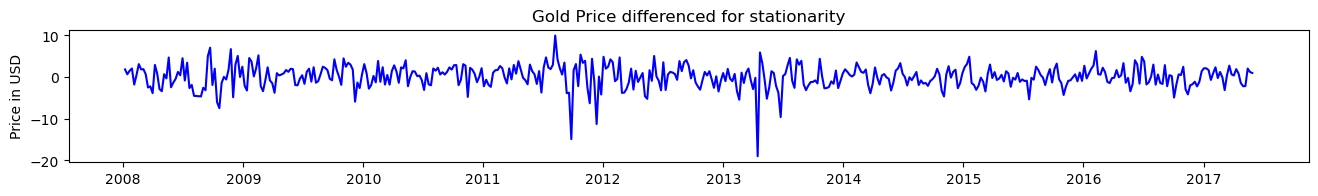

In [99]:
# Plotting differenced series of gold price
plt.figure(figsize=(16,10))
plt.subplot(511)  
plt.title("Gold Price differenced for stationarity")
#plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.plot(train['GLD-Diff1'], 'b-')

In [100]:
adfuller_test(train['GLD-Diff1'].dropna())

ADF Test Statistic : -18.982462466089164
p-value : 0.0
#Lags Used : 0
Number of Observations : 488
Critical Value : {'1%': -3.4438213751870337, '5%': -2.867480869596464, '10%': -2.5699342544006987}
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


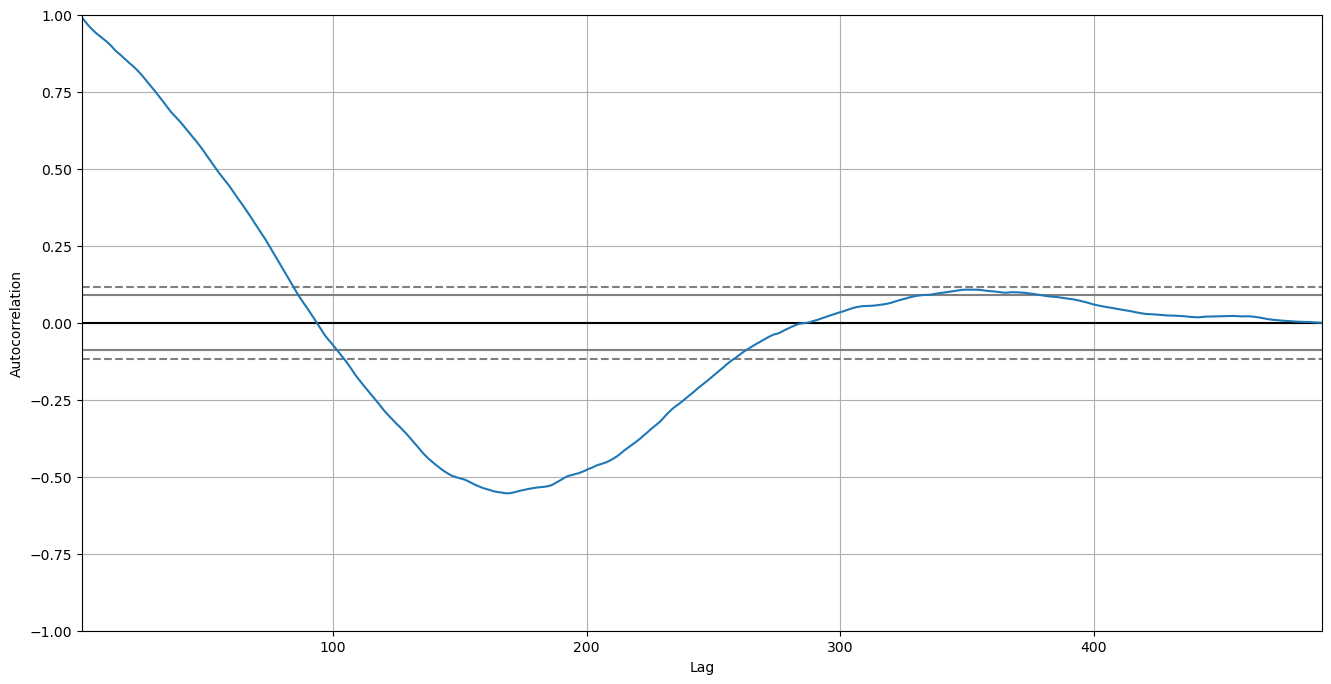

In [101]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train['GLD'].dropna())
plt.show()

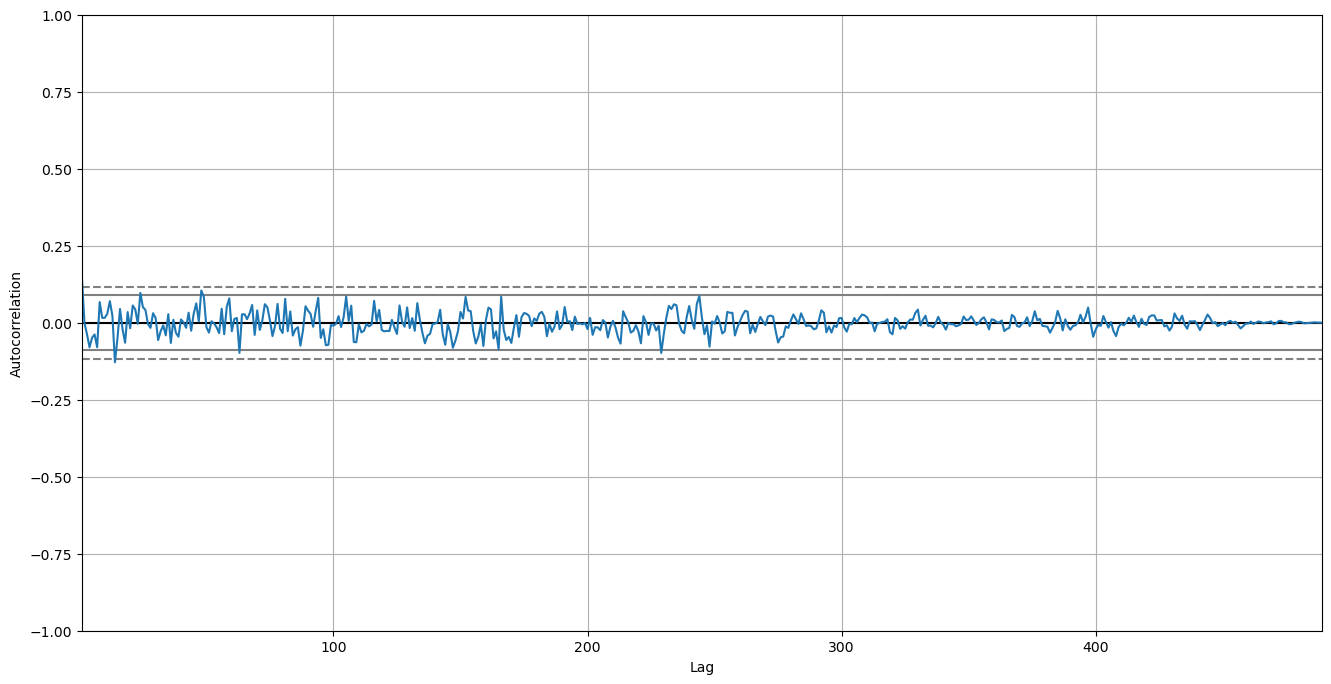

In [102]:
autocorrelation_plot(train['GLD-Diff1'].dropna())
plt.show()

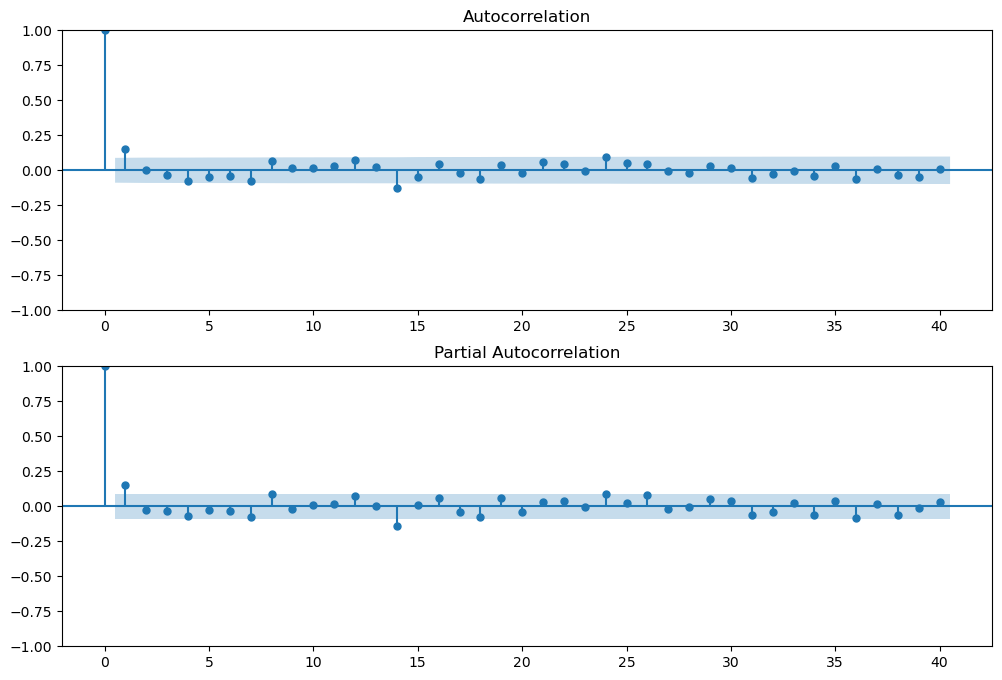

In [103]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train['GLD-Diff1'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train['GLD-Diff1'].dropna(),lags=40,ax=ax2,method='ywm') ## Yule Walker method

In [104]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['GLD'].dropna(),order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

c:\Users\tyagi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tyagi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tyagi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GLD   No. Observations:                  490
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1179.937
Date:                Fri, 01 Dec 2023   AIC                           2365.874
Time:                        23:44:06   BIC                           2378.451
Sample:                             0   HQIC                          2370.814
                                - 490                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0358      0.282      0.127      0.899      -0.517       0.589
ma.L1          0.1163      0.281      0.414      0.679      -0.434       0.667
sigma2         7.3008      0.237     30.845      0.000       6.837       7.765
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1014.98
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
# Lets see how this model performs on the train set...
train['forecast']=model_fit.predict()

C:\Users\tyagi\AppData\Local\Temp\ipykernel_1472\2206487294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['forecast']=model_fit.predict()


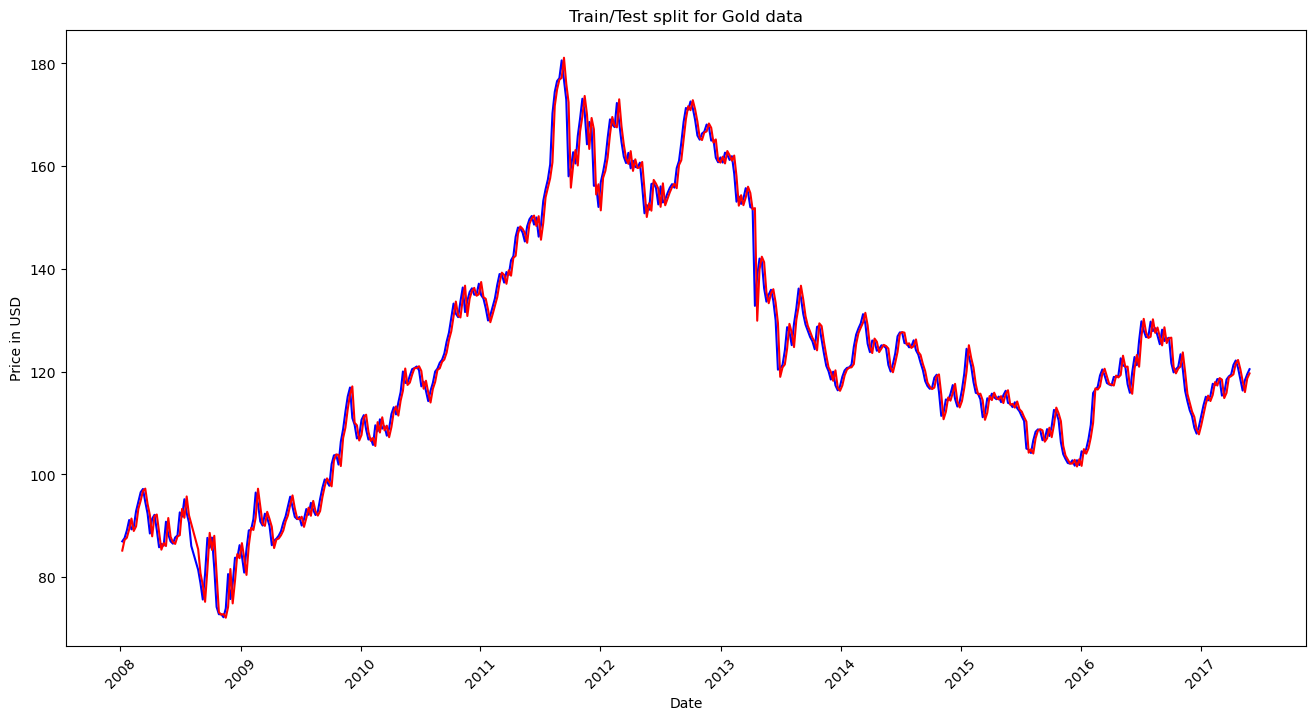

,SPX,GLD,USO,SLV,EUR/USD,GLD-Diff1,forecast
week_start,,,,,,,
2008-01-07,1407.369995,86.986000,74.783998,15.660200,1.490182,1.799334,85.186761
2008-01-14,1365.767969,87.629999,72.289999,15.903000,1.471862,0.643999,87.254884
2008-01-21,1332.944977,89.110000,70.722502,16.100000,1.468228,1.480002,87.696657
2008-01-28,1369.208032,91.142000,72.246000,16.639200,1.481120,2.031999,89.327317
2008-02-04,1342.421997,89.315999,70.648001,16.550600,1.482661,-1.826001,91.425744
...,...,...,...,...,...,...,...
2017-05-01,2389.287476,118.522501,9.865000,15.735000,1.092877,-2.217498,120.508271
2017-05-08,2397.592407,116.335001,9.760000,15.377500,1.088758,-2.187500,118.212223
2017-05-15,2381.434998,118.347500,10.182500,15.847500,1.108642,2.012499,116.038418


In [106]:
plt.plot(train[1:]['GLD'], color = "blue")
plt.plot(train[1:]['forecast'], color = "red")
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.xticks(rotation=45)
plt.title("Train/Test split for Gold data")
plt.show()

train[1:]

In [107]:
arima_rmse = np.sqrt(mean_squared_error(train[1:]['GLD'].values, train[1:]['forecast']))
print("RMSE: ",arima_rmse)

RMSE:  2.702040561304528


In [108]:
arima_train_mae = mean_absolute_error(train[1:]['GLD'].values, train[1:]['forecast'])
print("MAE: ",arima_train_mae)

MAE:  2.0174127379499254


In [109]:
weekly_full_forecast=model_fit.predict(start=0,end=539)

c:\Users\tyagi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [110]:
weekly_full_forecast.index = weekly_data_idx.index

In [111]:
weekly_data_idx['forecast'] = weekly_full_forecast

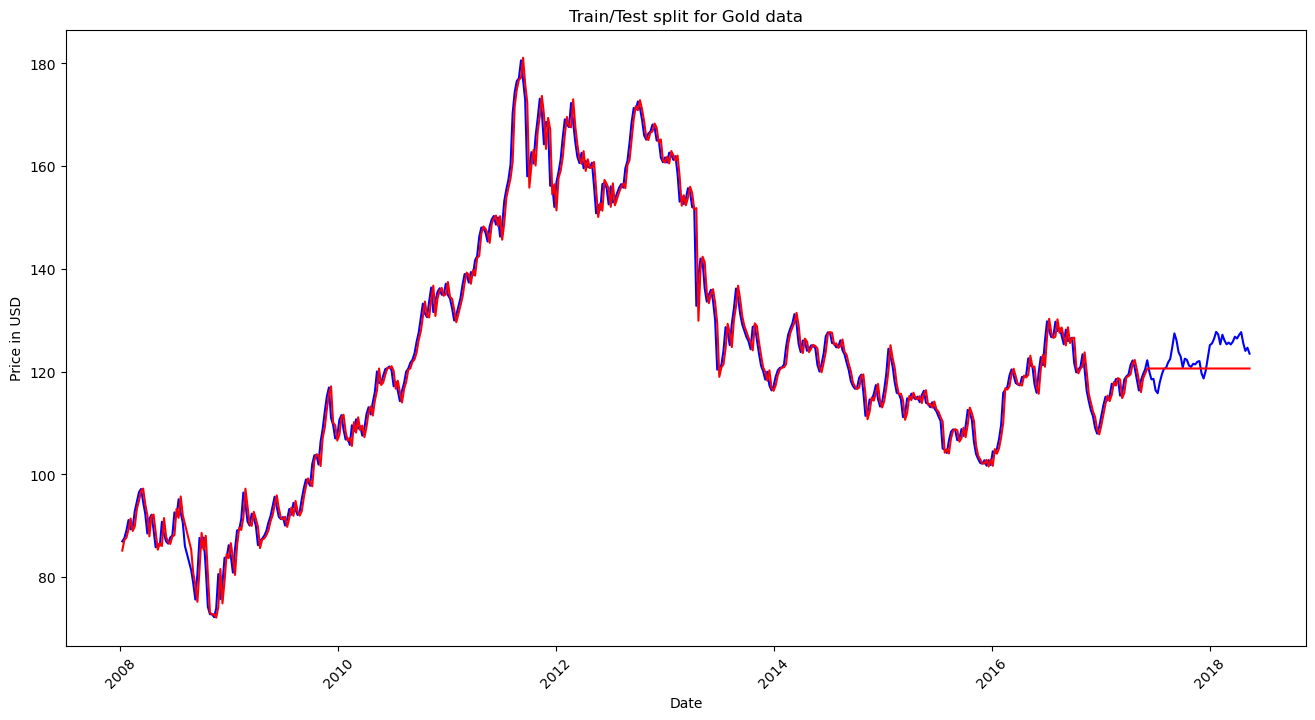

In [113]:
plt.plot(weekly_data_idx[1:]['GLD'], color = "blue")
plt.plot(weekly_data_idx[1:]['forecast'], color = "red")
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.xticks(rotation=45)
plt.title("Train/Test split for Gold data")
plt.show()

In [56]:
print("rows and columns in train : ",train.shape)
print("rows and columns in train : ",test.shape)
train.tail(10)

rows and columns in train :  (490, 6)
rows and columns in train :  (50, 6)


,SPX,GLD,USO,SLV,EUR/USD,GLD-Diff1
week_start,,,,,,
2017-03-27,2357.337524,119.092501,10.282500,17.182500,1.078134,0.610500
2017-04-03,2357.359985,119.442501,10.700000,17.287500,1.066688,0.350000
2017-04-10,2346.204956,121.317499,11.137500,17.325000,1.062399,1.874998
2017-04-17,2346.302490,122.187500,10.815000,17.252500,1.070078,0.870001
2017-04-24,2384.744995,120.739999,10.277500,16.650000,1.089157,-1.447501
2017-05-01,2389.287476,118.522501,9.865000,15.735000,1.092877,-2.217498
2017-05-08,2397.592407,116.335001,9.760000,15.377500,1.088758,-2.187500
2017-05-15,2381.434998,118.347500,10.182500,15.847500,1.108642,2.012499
2017-05-22,2402.974976,119.532501,10.455000,16.222500,1.121496,1.185001


In [137]:
weekly_data['forecast']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
535   NaN
536   NaN
537   NaN
538   NaN
539   NaN
Name: forecast, Length: 540, dtype: float64

In [133]:
weekly_data.tail(50)

,week_start,SPX,GLD,USO,SLV,EUR/USD,forecast
490,2017-06-05,2433.090027,122.232500,9.665000,16.632500,1.124206,NaN
491,2017-06-12,2435.029968,119.995001,9.382500,15.955000,1.119195,NaN
492,2017-06-19,2440.150024,118.512499,8.890000,15.605000,1.114959,NaN
493,2017-06-26,2429.709961,118.597500,9.110000,15.780000,1.133675,NaN
494,2017-07-03,2423.766683,116.359998,9.393333,15.210000,1.138101,NaN
495,2017-07-10,2438.870036,115.823334,9.356667,14.970000,1.143226,NaN
496,2017-07-17,2466.757507,117.930001,9.572500,15.355000,1.154531,NaN
497,2017-07-24,2475.072449,119.474998,9.832500,15.650000,1.167502,NaN
498,2017-07-31,2474.095032,120.597500,10.132500,15.770000,1.184287,NaN
499,2017-08-07,2467.014954,120.722500,10.055000,15.762500,1.177183,NaN
